# Modelos de segmentación basados en procesos de vectorización

La vectorización es el proceso de generar vectores a partir de contornos o ejes de una imagen. Se emplea comúnmente en el tratamiento digital, contenido web y procesamiento CAD (Computer Aided Design), empleando formatos de vectores como .pdf, .dxf, .svg, etc. Una ventaja del formato vectorial es la escalabilidad y manipulación que ofrece a diferencia de los formatos basados en píxeles o mapas de bits. Algunos de dichos formatos admiten tridimensionalidad, siendo muy empleados en impresión 3D, corte y grabado láser o CNC (Computer Numerical Control).  
  
En esta actividad se pretende combinar procesos de segmentación y vectorización, que, aunque es una unión natural e indivisible, la intención es extraer "features" o características de la imágen como el color, la linealidad o agregabilidad; procesadas posteriormente en modelos tridimensionales y populados con datos, dándoles "una segunda intención" a esas características.

## 1. Segmentación cromática y reasignación de propiedades o elevaciones  
### Enfoque centrado en elementos superficiales

En este primer experimento se investiga la segmentación de manchas como entidades topográficas, es decir, con asignación de contornos y elevaciones diferenciadas, así como otras propiedades.

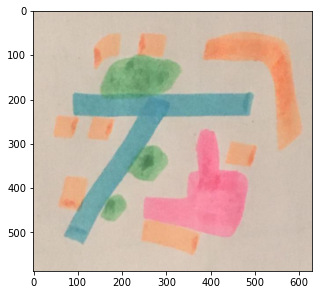

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('colores.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #Pasamos a colores HSV.

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

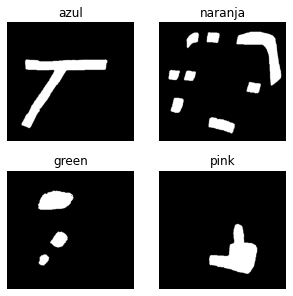

In [18]:
blue_bot = np.array([79,25,50])
blue_top = np.array([119,155,187])
blue_mask = cv2.inRange(hsv, blue_bot, blue_top)

orange_bot = np.array([1,80,5])
orange_top = np.array([50,190,255])
orange_mask = cv2.inRange(hsv, orange_bot, orange_top)

green_bot = np.array([50,52,63])
green_top = np.array([80,128,233])
green_mask = cv2.inRange(hsv, green_bot, green_top)

pink_bot = np.array([150,50,20])
pink_top = np.array([180,240,255])
pink_mask = cv2.inRange(hsv, pink_bot, pink_top)
 
#La segmentación arroja mejores resultados empleando operaciones morfológicas (apertura) sobre las máscaras.
#Conclusión extraída de la comprobación de distintas imágenes realizadas con los mismos colores bajo distinta iluminación. 
def smooth (mask): 
    p = 7
    n = int((p-1)/2) 
    se = np.zeros((p,p), np.uint8)
    cv2.circle(se,(n,n), n, 1, -1)
    mask = cv2.erode(mask, se)
    mask = cv2.dilate(mask, se)
    return(mask)

blue_mask = smooth(blue_mask)
orange_mask = smooth(orange_mask)
green_mask = smooth(green_mask)
pink_mask = smooth(pink_mask)

plt.rcParams['figure.figsize'] = [5, 5]
fig, ((ax1, ax2), (bx1, bx2)) = plt.subplots(2,2)
ax1.imshow(blue_mask, cmap="gray")
ax1.set_title('azul')
ax1.axis('off')
ax2.imshow(orange_mask, cmap="gray")
ax2.set_title('naranja')
ax2.axis('off')
bx1.imshow(green_mask, cmap="gray")
bx1.set_title('green')
bx1.axis('off')
bx2.imshow(pink_mask, cmap="gray")
bx2.set_title('pink')
bx2.axis('off')
plt.show()

Una vez realizadas las segmentaciones se procederá a la vectorización y asignación de características.  
Se empleará la librería **dxfwrite**, la cual es preciso instalar previamente (https://pypi.org/project/dxfwrite/).  
Nótese que existen nuevas versiones bajo el nombre de **ezdxf**.

In [19]:
pip install dxfwrite

Note: you may need to restart the kernel to use updated packages.


In [20]:
from dxfwrite import DXFEngine as dxf

#CREACIÓN DE ARCHIVO Y CAPAS
drawing = dxf.drawing('Capitulo1.dxf')

drawing.add_layer('01-Red', color=1)
drawing.add_layer('02-Yellow', color=2)
drawing.add_layer('03-Green', color=3)
drawing.add_layer('04-Cyan', color=4)
drawing.add_layer('05-Blue', color=5)
drawing.add_layer('06-Magenta', color=6)
drawing.add_layer('30-Orange', color=30)

discretization=0.01

def draw (mask, layer, discretization):
    contour,hierarchy = cv2.findContours(mask, 1, 2)
    for region in contour:
        epsilon = discretization * cv2.arcLength(region,True)
        approx = cv2.approxPolyDP(region,epsilon,True)  
        #Convertimos la aproximación Ramer–Douglas–Peucker a una lista de tuplas para poder transferir coordenadas.
        pol = []
        for point in approx:
            pol.append(tuple(point.reshape((2))))
        pol.append(pol[0])
        #Pasamos las coordenadas "y" a valor negativo ya que los sistemas de coordenadas dxf son inversos.
        mirror_pol=[]
        for i in pol:
            i0=i[0]
            i1=i[1]*(-1)
            mirror_pol.append((i0,i1))
            
        drawing.add(dxf.polyline(mirror_pol, layer=layer))
    
draw (blue_mask,'04-Cyan',discretization)   
draw (orange_mask,'30-Orange',discretization)    
draw (green_mask,'03-Green',discretization)    
draw (pink_mask,'06-Magenta',discretization)     
    
drawing.save()

<img src="resultados1a.png" width="900"/>

El método **cv2.approxPolyDP** se fundamenta en el algoritmo de Ramer–Douglas–Peucker, el cual discretiza el número de nodos de un contorno o polilínea en función de su longitud mediante una variable epsilon.  
Se muestran resultados sin discretización (imagen de la izquierda), y con discretización (derecha). Este último representa además el resultado del archivo generado previamente, "Capitulo1.dxf".   

 Aunque la librería **dxfwrite** presenta muchas herramientas no dispone de efectivas herramientas de modelado. Puede automatizarse un modelado de los resultados obtenidos con una implementación Lisp sobre nuestro entorno Cad (Admisible por las verticales Autocad, BabaCad, ArchiCad, etc). Para este ejercicio se emplea el archivo adjunto "model.lsp".

De esta forma, combinando Python y Lisp obtenemos un modelo .dxf tridimensional de un dibujo 2D que admite impresión 3D o análisis de maquetas virtuales (para estudios de soleamiento, sombras arrojadas, visibilidad, etc):

<img src="resultados1b.png" width="600"/>

A continuación se muestra también el resultado de colorear un plano, en donde se desprecia el ruido de fondo como líneas o manchas de otros colores. 
Nótese que la segmentación obvia las líneas negras, por lo que figuras como el coche rosa parecen más onduladas. Esto no es un defecto en sí, sino que resulta del hecho de que el rosa no se ajusta a dichas lineas negras:

<img src="resultados1c.png" width="600"/>

## 2. Segmentación cromática y reasignación de individuos 
### Enfoque centrado en elementos lineales y puntuales

En este segundo experimento se investiga la segmentación de manchas como iconos, elementos lineales o abstractos; que pueden representarse a distintas escalas o alturas.

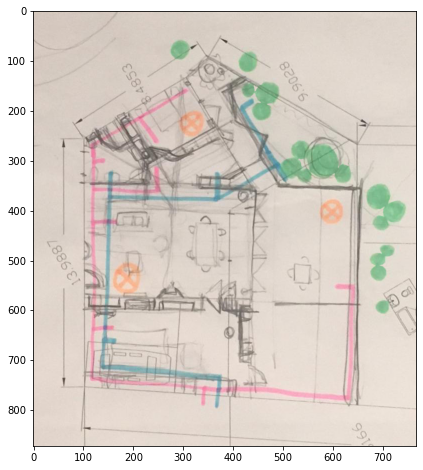

In [21]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('complejo.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #Pasamos a colores HSV.

plt.rcParams['figure.figsize'] = [7, 8]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
blue_bot = np.array([79,25,50])
blue_top = np.array([119,155,187])
blue_mask = cv2.inRange(hsv, blue_bot, blue_top)

orange_bot = np.array([1,80,5])
orange_top = np.array([50,190,255])
orange_mask = cv2.inRange(hsv, orange_bot, orange_top)

green_bot = np.array([50,52,63])
green_top = np.array([80,128,233])
green_mask = cv2.inRange(hsv, green_bot, green_top)

pink_bot = np.array([150,50,20])
pink_top = np.array([180,240,255])
pink_mask = cv2.inRange(hsv, pink_bot, pink_top)

#En este experimento cada valor crómatico precisa una segmentación diferente. Se definen 3 funciones a continuación.
def extract_trunks (mask): 
    p = 7
    n = int((p-1)/2) 
    se = np.zeros((p,p), np.uint8)
    cv2.circle(se,(n,n), n, 1, -1)
    mask = cv2.erode(mask, se)
    mask = cv2.dilate(mask, se)

    #Transformada de distancia para aislar clusters en contacto.
    dist_transform = cv2.distanceTransform(green_mask,cv2.DIST_L2, 0)
    cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    ret, mask = cv2.threshold(dist_transform, 0.31 * dist_transform.max(), 255, 0)
    #Los siguientes resultados se muestran más abajo.
    #cv2.imshow('distancia', dist_transform)
    #cv2.imshow('mascara_resultante', mask)
    mask = np.array(mask,np.uint8)

    return(mask)

def extract_icon (mask): 
    p = 15
    n = int((p-1)/2) 
    se = np.zeros((p,p), np.uint8)
    cv2.circle(se,(n,n), n, 1, -1)
    mask = cv2.dilate(mask, se)
    mask = cv2.erode(mask, se)
    mask = cv2.erode(mask, se)
    mask = cv2.dilate(mask, se)

    return(mask)

def smooth_path (mask): 
    p = 13
    n = int((p-1)/2) 
    se = np.zeros((p,p), np.uint8)
    cv2.circle(se,(n,n), n, 1, -1)
    mask = cv2.dilate(mask, se)
    mask = cv2.erode(mask, se)
    mask = np.array(mask)
    mask[mask > 0] = 1
    
    #Para generar los ejes se emplea le método de skeletonización, útil para elementos lineales.
    mask = skeletonize(mask)
    mask = np.array(mask,np.uint8)
    mask = np.add(mask,0)
    mask[mask == 0] = 0
    mask[mask == 1] = 255

    return(mask)

blue_mask=smooth_path(blue_mask)
orange_mask=extract_icon(orange_mask)
green_mask=extract_trunks(green_mask)
pink_mask=smooth_path(pink_mask)

#Solicitamos que OpenCV nos muestre los fg de cada segmentación, ya que skeletonize no se aprecia bien en matplot.
cv2.imshow('blue_mask', blue_mask)
cv2.imshow('orange_mask', orange_mask)
cv2.imshow('green_mask', green_mask)
cv2.imshow('pink_mask', pink_mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

Dentro de la función "extract_trunks" se obtiene una segmentación por distancia, empleada para separar los clusters en contacto y poder definirlos como entidades separadas. El resultado se muestra a continuación.

<img src="resultados2a.png" width="600"/>

In [24]:
from dxfwrite import DXFEngine as dxf

#CREACIÓN DE ARCHIVO Y CAPAS
drawing = dxf.drawing('Capitulo2.dxf')

drawing.add_layer('01-Red', color=1)
drawing.add_layer('02-Yellow', color=2)
drawing.add_layer('03-Green', color=3)
drawing.add_layer('04-Cyan', color=4)
drawing.add_layer('05-Blue', color=5)
drawing.add_layer('06-Magenta', color=6)
drawing.add_layer('30-Orange', color=30)

#CREACIÓN DE BLOQUES
#LÁMPARAS
lamp = dxf.block(name='lamp', basepoint=(0,0,0))
drawing.blocks.add(lamp)

lamp.add(dxf.polyline(((0,0,0),(0,0,25)), layer='30-Orange'))
lamp.add(dxf.polyline(((-10,10,25),(-10,-10,25),(10,-10,25),(10,10,25),(-10,10,25)), layer='30-Orange'))
lamp.add(dxf.polyline(((-5,5,50),(-5,-5,50),(5,-5,50),(5,5,50),(-5,5,50)), layer='30-Orange'))
lamp.add(dxf.polyline(((-5,-5,50),(-10,-10,25)), layer='30-Orange'))
lamp.add(dxf.polyline(((-5,5,50),(-10,10,25)), layer='30-Orange'))
lamp.add(dxf.polyline(((5,-5,50),(10,-10,25)), layer='30-Orange'))
lamp.add(dxf.polyline(((5,5,50),(10,10,25)), layer='30-Orange'))

#ÁRBOLES
tree = dxf.block(name='tree', basepoint=(0,0,0))
drawing.blocks.add(tree)

tree.add(dxf.polyline(((0,0,0),(0,0,50)), layer='03-Green'))
tree.add(dxf.circle(8.9, (0,0,26.6), layer='03-Green'))
tree.add(dxf.circle(8.9, (0,0,73.35), layer='03-Green'))
tree.add(dxf.circle(25, (0,0,50), layer='03-Green'))
tree.add(dxf.circle(20.8, (0,0,36.19), layer='03-Green'))
tree.add(dxf.circle(20.8, (0,0,63.8), layer='03-Green'))

discretization=0.005

#Al igual que sucedía con la segmentación, la asignación vectorial es independiente para cada tipo de elemento.
#Por lo que se definen 3 funciones.

def draw (mask, layer, discretization):
    contour,hierarchy = cv2.findContours(mask, 1, 2)
    for region in contour:
        epsilon = discretization * cv2.arcLength(region,True)
        approx = cv2.approxPolyDP(region,epsilon,True)  
        
        pol = []
        for point in approx:
            pol.append(tuple(point.reshape((2))))
        pol.append(pol[0])
        
        mirror_pol=[]
        for i in pol:
            i0=i[0]
            i1=i[1]*(-1)
            mirror_pol.append((i0,i1))
            
        drawing.add(dxf.polyline(mirror_pol, layer=layer))

def draw_line (mask, layer, z):           
    minLineLength = 1000
    maxLineGap = 0
    lines = cv2.HoughLinesP(mask,1,np.pi/180,5,minLineLength,maxLineGap)
    
    for i in lines:  
        a1=tuple(i.reshape((2,2))[0])
        a2=tuple(i.reshape((2,2))[1])
        p1=(a1[0],a1[1]*(-1),z)
        p2=(a2[0],a2[1]*(-1),z)
        l=[p1,p2]
        drawing.add(dxf.polyline(l, layer=layer))


def draw_block (mask, layer, block):           
    contour,hierarchy = cv2.findContours(mask, 1, 2)
    for region in contour:
        
        M = cv2.moments(region)
        cx = int(M['m10']/M['m00'])
        cy = (int(M['m01']/M['m00']))*(-1)
        
        drawing.add(dxf.insert(block, insert=(cx,cy), xscale=1, yscale=1, zscale=1))
        
draw_line (blue_mask,'04-Cyan',50)   
draw_block (orange_mask,'30-Orange','lamp')    
draw_block (green_mask,'03-Green','tree')    
draw_line (pink_mask,'06-Magenta',0)     
    
drawing.save()

El resultado del archivo generado, "Capitulo2.dxf", se muestra a continuación en un gif animado. Los objetos árbol se han separado correctamente y a cada cluster le corresponde un elemento árbol. Las luminarias igualmente. La red de agua fría y agua caliente también se muestra a distinta altura.

![SegmentLocal](resultados2b.gif "segment")

Las propiedades de cada elemento son inducidas en función de nuestros intereses y del valor cromático y formal de la imagen. A continuación se muestran algunas propiedades de un objeto árbol desde la aplicación Autocad.

<img src="resultados2c.png" width="600"/>

## 3. Segmentación formal y escalable
### Enfoque centrado en iconografías, leyendas y documentos técnicos

En este último experimento el objetivo es aplicar los procedimientos previos para poder ajustar la imagen a una escala real y específica de un plano, ajustar la perspectiva y, por último, segmentar distintas formas para un mismo color.  
Estas particularidades son comunes en planos de revisión y modificaciones en arquitectura, ingeniería civil, instalaciones, etc. Cuando la información presente es considerable, a menudo se emplea un mismo color para distintos tipos o subtipos de elementos, que sólo se diferencian por su forma o patrón (sombreados) en la leyenda.

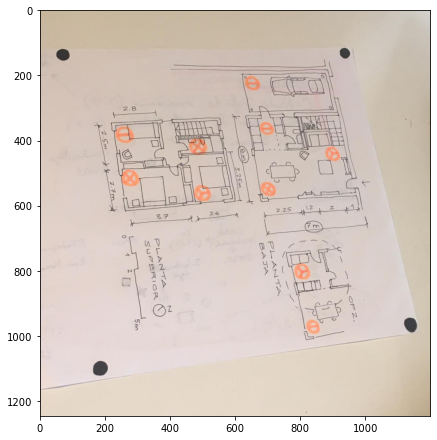

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('perspectiva.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)   #Pasamos a colores HSV.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Pasamos a grises.

plt.rcParams['figure.figsize'] = [7, 8]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

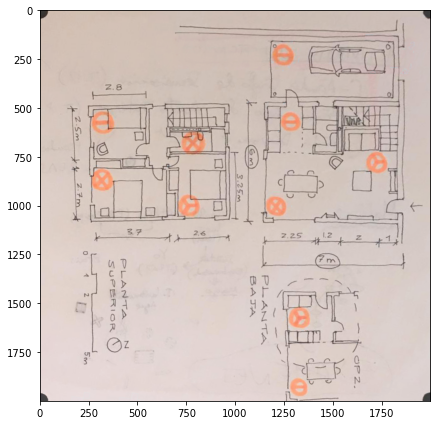

In [26]:
#Umbralización. Los que estén encima de 200 los pasa a 255, el resto a 0. Luego invierte el resultado.
ret,markers = cv2.threshold(gray,80,255,cv2.THRESH_BINARY_INV) 
markers = np.array(markers,np.uint8)

def opening (mask,se): 
    p = se
    n = int((p-1)/2) 
    se = np.zeros((p,p), np.uint8)
    cv2.circle(se,(n,n), n, 1, -1)
    mask = cv2.erode(mask, se)
    mask = cv2.dilate(mask, se)   
    return(mask)

def closing (mask,se): 
    p = se
    n = int((p-1)/2) 
    se = np.zeros((p,p), np.uint8)
    cv2.circle(se,(n,n), n, 1, -1)
    mask = cv2.dilate(mask, se) 
    mask = cv2.erode(mask, se)
    return(mask)

markers = opening(markers,15)

#Una vez obtenidas las 4 esquinas extraemos sus centroides y distorsionamos la imagen.
def get_points (mask):   
    points=[]        
    contour,hierarchy = cv2.findContours(mask, 1, 2)
    for region in contour:
        
        M = cv2.moments(region)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        points.append([cx,cy])
    return(points)

#corners serán las coordenadas de las esquinas obtenidas.
corners = get_points(markers)
corners = np.array(corners, np.float32)


#sabiendo que la distancia entre esquinas es 20m podemos ajustarlo a 2000 píxeles.
dist = 2000
#corners2 serán las nuevas esquinas
corners2 = np.float32([[ 0,dist],
                       [dist,dist],
                       [ 0, 0],
                       [dist, 0]])

M = cv2.getPerspectiveTransform(corners,corners2)
#distort es la imagen original readaptada a su tamaño.
distort = cv2.warpPerspective(hsv, M, (dist,dist))

plt.rcParams['figure.figsize'] = [7, 8]
plt.imshow(cv2.cvtColor(distort, cv2.COLOR_HSV2RGB))
plt.show()

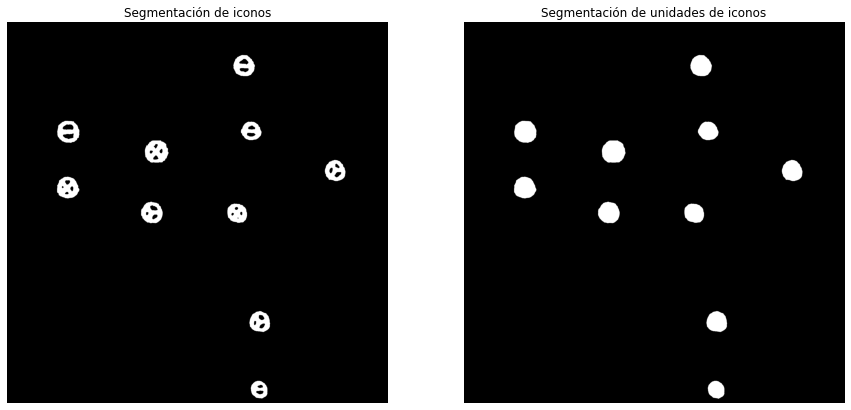

In [27]:
#Una vez ajustada la imagen extraemos la máscara para colores naranjas.
orange_bot = np.array([1,80,5])
orange_top = np.array([50,190,255])
orange_mask = cv2.inRange(distort, orange_bot, orange_top)

#Nos interesa segmentar la forma de los iconos y por otro lado, las unidades de iconos como clusters.
orange_mask = opening(orange_mask,11)
orange_mask = closing(orange_mask,5)
orange_mask_items = closing(orange_mask,51)

plt.rcParams['figure.figsize'] = [15, 30]
fig, ((ax1, ax2)) = plt.subplots(1,2)
ax1.imshow(orange_mask, cmap="gray")
ax1.set_title('Segmentación de iconos')
ax1.axis('off')
ax2.imshow(orange_mask_items, cmap="gray")
ax2.set_title('Segmentación de unidades de iconos')
ax2.axis('off')
plt.show()

In [28]:
#Por un lado contaremos el número de regiones totales, esto es, de unidades.
contour,hierarchy = cv2.findContours(orange_mask_items, 1, 2)
k = (len(contour))

#Por otro lado obtendremos las centroides de los iconos tal cual.
#Este mecanismo nos añade también los vacíos background anidados en los iconos.
contour,hierarchy = cv2.findContours(orange_mask, 1, 2)
subpoints = []
for region in contour:        
    M = cv2.moments(region)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    subpoints.append([cx,cy])

print("Centroides foreground y background presentes en la segmentación de iconos:")
print(subpoints)
print("")
print("Total de iconos = " + str(k))

Centroides foreground y background presentes en la segmentación de iconos:
[[1327, 1943], [1329, 1912], [1323, 1929], [1339, 1595], [1301, 1579], [1334, 1550], [1327, 1573], [1212, 1028], [775, 1021], [1183, 1008], [735, 1004], [1229, 1004], [1204, 978], [769, 976], [1207, 1003], [760, 1000], [313, 898], [340, 874], [291, 866], [317, 840], [318, 869], [1736, 799], [1700, 778], [1732, 755], [1722, 780], [780, 712], [756, 681], [808, 677], [781, 650], [784, 680], [323, 598], [1280, 590], [1283, 554], [321, 551], [1281, 572], [321, 575], [1244, 250], [1244, 208], [1243, 229]]

Total de iconos = 10


In [29]:
#Utilizando el método de aprendizaje no supervisado k-means podemos etiquetar cada agrupación.
#La estrategia consiste en emplear K = Total de iconos, y etiquetarlos en función de la frecuencia de vacíos anidados.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, random_state=0).fit(subpoints)
print(kmeans.labels_)

[2 2 2 6 6 6 6 1 7 1 7 1 1 7 1 7 8 8 8 8 8 5 5 5 5 4 4 4 4 4 0 9 9 0 9 0 3
 3 3]


Como puede observarse, con el fin de poder emplearse el algoritmo para diversos casos, k se reasigna en función del total de iconos, evitando así que sea introducido por el usuario de manera manual. Esa es la razón por la que previamente se han generado dos segmentaciones con diferentes operaciones morfológicas (segmentación de unidades de iconos y segmentación de iconos). Una se emplea para contabilizar, la otra para etiquetar cada caso.

In [30]:
#A continuación se muestran todos los cluster (del 0 al 9 para este ejemplo) y los centroides que posee cada uno.
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[0 3]
 [1 5]
 [2 3]
 [3 3]
 [4 5]
 [5 4]
 [6 4]
 [7 4]
 [8 5]
 [9 3]]


Este array de frecuencias sugiere una correcta segmentación ya que las frecuencias de cada cluster son 3, 4 y 5, es decir, las deseadas para etiquetar cada icono como tipo A, tipo B y tipo C.  
En la figura mostrada a continuación se refleja este concepto: Los iconos A, B y C presentan 3, 4 y 5 centroides respectivamente (puntos rojos), que corresponden al centroide de su foreground más los centroides de sus backgrounds anidados. Esta característica es útil para reconocerlos y etiquetarlos.

<img src="resultados3a.png" width="600"/>

El icono de centroide 1323,1929
Es de tipo A

El icono de centroide 1327,1573
Es de tipo B

El icono de centroide 1208,1003
Es de tipo C

El icono de centroide 760,1000
Es de tipo B

El icono de centroide 318,870
Es de tipo C

El icono de centroide 1722,780
Es de tipo B

El icono de centroide 784,680
Es de tipo C

El icono de centroide 1281,572
Es de tipo A

El icono de centroide 321,575
Es de tipo A

El icono de centroide 1243,229
Es de tipo A

TOTAL:
Hay 4 lámparas del tipo A.
Hay 3 lámparas del tipo B.
Hay 3 lámparas del tipo C.


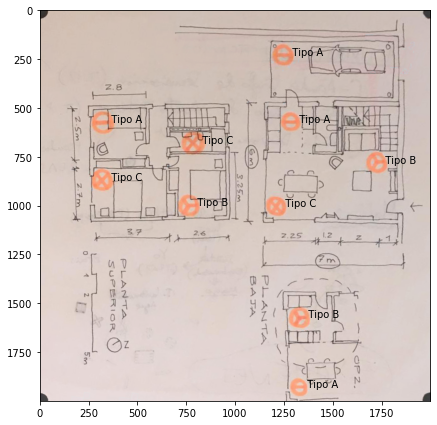

In [31]:
contour,hierarchy = cv2.findContours(orange_mask_items, 1, 2)

plt.rcParams['figure.figsize'] = [7, 8]        
plt.imshow(cv2.cvtColor(distort, cv2.COLOR_HSV2RGB))

for region in contour:        
    M = cv2.moments(region)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    print("El icono de centroide " + str(cx) + "," + str(cy))
    check_label = int(kmeans.predict([[cx,cy]]))
    if frequencies[check_label][1] == 3:
        print("Es de tipo A")
        plt.text(cx, cy, "   Tipo A")
    if frequencies[check_label][1] == 4:
        print("Es de tipo B")
        plt.text(cx, cy, "   Tipo B")
    if frequencies[check_label][1] == 5:
        print("Es de tipo C")
        plt.text(cx, cy, "   Tipo C")
    print("")
    
labels=[]
for i in frequencies:
    labels.append(i[1])
(unique, label_counts) = np.unique(labels, return_counts=True)
type_counts = np.asarray((unique, label_counts)).T

print("TOTAL:")

  
for i in type_counts:
    if i[0]==3:
        print("Hay " + str(i[1]) + " lámparas del tipo A.")
    if i[0]==4:
        print("Hay " + str(i[1]) + " lámparas del tipo B.")
    if i[0]==5:
        print("Hay " + str(i[1]) + " lámparas del tipo C.")


plt.show()  

La clasificación en la imagen muestra resultados precisos en función de la forma de los iconos. La siguiente celda se encarga de vectorizar los resultados y generar el .dxf.

In [32]:
from dxfwrite import DXFEngine as dxf

#CREACIÓN DE ARCHIVO Y CAPAS
drawing = dxf.drawing('Capitulo3.dxf')

drawing.add_layer('0-Frame', color=7)
drawing.add_layer('30-Orange', color=30)

#CREACIÓN DEL MARCO DE REFERENCIA
drawing.add(dxf.polyline(((0,0),(0,-dist),(dist,-dist),(dist,0),(0,0)), layer='0-Frame'))
drawing.add(dxf.circle(50, (0,0), layer='0-Frame'))
drawing.add(dxf.circle(50, (0,-dist), layer='0-Frame'))
drawing.add(dxf.circle(50, (dist,-dist), layer='0-Frame'))
drawing.add(dxf.circle(50, (dist,0), layer='0-Frame'))

#CREACIÓN DE BLOQUES
#LÁMPARAS
type_a = dxf.block(name='type_a', basepoint=(0,0,0))
drawing.blocks.add(type_a)
type_a.add(dxf.polyline(((0,0,0),(0,0,15)), layer='30-Orange'))
type_a.add(dxf.polyline(((0,0,15),(10,0,25),(0,0,35)), layer='30-Orange'))
type_a.add(dxf.polyline(((0,0,15),(-10,0,25),(0,0,35)), layer='30-Orange'))
type_a.add(dxf.polyline(((0,0,15),(0,10,25),(0,0,35)), layer='30-Orange'))
type_a.add(dxf.polyline(((0,0,15),(0,-10,25),(0,0,35)), layer='30-Orange'))
type_a.add(dxf.polyline(((10,0,25),(0,10,25),(-10,0,25),(0,-10,25),(10,0,25)), layer='30-Orange'))

type_b = dxf.block(name='type_b', basepoint=(0,0,0))
drawing.blocks.add(type_b)
type_b.add(dxf.polyline(((0,0,0),(0,0,25)), layer='30-Orange'))
type_b.add(dxf.polyline(((0,0,25),(0,10,25),(-2.88,12.88,25),(2.88,12.88,25),(0,10,25)), layer='30-Orange'))
type_b.add(dxf.polyline(((0,0,25),(-8.66,-5,25),(-12.59,-3.94,25),(-9.71,-8.93,25),(-8.66,-5,25)), layer='30-Orange'))
type_b.add(dxf.polyline(((0,0,25),(8.66,-5,25),(12.59,-3.94,25),(9.71,-8.93,25),(8.66,-5,25)), layer='30-Orange'))

type_c = dxf.block(name='type_c', basepoint=(0,0,0))
drawing.blocks.add(type_c)
type_c.add(dxf.polyline(((0,0,0),(0,0,25)), layer='30-Orange'))
type_c.add(dxf.polyline(((-10,10,25),(-10,-10,25),(10,-10,25),(10,10,25),(-10,10,25)), layer='30-Orange'))
type_c.add(dxf.polyline(((-5,5,50),(-5,-5,50),(5,-5,50),(5,5,50),(-5,5,50)), layer='30-Orange'))
type_c.add(dxf.polyline(((-5,-5,50),(-10,-10,25)), layer='30-Orange'))
type_c.add(dxf.polyline(((-5,5,50),(-10,10,25)), layer='30-Orange'))
type_c.add(dxf.polyline(((5,-5,50),(10,-10,25)), layer='30-Orange'))
type_c.add(dxf.polyline(((5,5,50),(10,10,25)), layer='30-Orange'))

def draw_block (scale):           
    contour,hierarchy = cv2.findContours(orange_mask_items, 1, 2)
    for region in contour:        
        M = cv2.moments(region)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        check_label = int(kmeans.predict([[cx,cy]]))
        if frequencies[check_label][1] == 3:
            drawing.add(dxf.insert('type_a', insert=(cx,-cy), xscale=scale, yscale=scale, zscale=scale))
        if frequencies[check_label][1] == 4:
            drawing.add(dxf.insert('type_b', insert=(cx,-cy), xscale=scale, yscale=scale, zscale=scale))
        if frequencies[check_label][1] == 5:
            drawing.add(dxf.insert('type_c', insert=(cx,-cy), xscale=scale, yscale=scale, zscale=scale))
        print("")

draw_block(2)

drawing.save()

El archivo generado, "Capitulo3.dxf", muestra el resultado deseado (figuras a continuación).  
El reconocimiento de los vértices arroja el formato esperado: espacio cuadrangular para este ejemplo.  
La escala y proporción de los objetos es la adecuada: se evalua la distancia entre los vértices de la imagen.  
La clasificación ha sido efectiva: los bloques se corresponden con las entidades de la imagen.

<img src="resultados3b.png" width="900"/>

## Conclusiones
- La segmentación mediante **rangos cromáticos** es efectiva para manchas procedentes de rotuladores y marcadores propios de edición documental, ya que éstos se diferencian fácilmente mediante **valores hsv**.
- Los **operadores morfológios** son esenciales para eliminar ruido de las segmentaciones y aislar unos objetos de otros.
- Los contornos pueden discretizarse mediante el **algoritmo de Ramer–Douglas–Peucker** con el fin de generar resultados  geométricos.
- Los elementos líneales pueden extraerse mediante **algoritmos de skeletonización**. Éstos se basan en iteraciones sucesivas que se interrumpen en caso de perder conectividad dando lugar a geometrías de delgadez máxima.
- Los elementos puntuales o bloques pueden insertarse en el **centroide** de las manchas o clusters. En caso de contactar o encontrarse muy próximas a otras manchas las soluciones basadas en **transformadas de distancias** son efectivas.
- Es preciso disponer de referencias para escalar los modelos y ajustar la perspectiva de las imágenes. En la actividad se propone un marco de 4 vértices reconocibles.
- Es posible reconocer geometrías simples sin necesidad de recurrir a entrenamientos complejos o clasificadores en cascada. Se propone emplear procedimientos basados en **modelos de aprendizaje automático no supervisado k-means**, etiquetando cada cluster en función de sus vacíos anidados.
- En todos los casos se precisa un conocimiento previo de las imágenes a evaluar. Ejemplos de mal uso:
    - Emplear colores verdes como elementos lineales no arrojaría resultados válidos (proporcionaría contornos y no ejes).
    - Emplear símbolos naranjas con contenido en cruz y en aspa arrojarían el mismo resultado, ya que mostrarían 5 centroides y quedarían etiquetados en la misma categoría: lámparas tipo C.  
- Estos ejemplos corroboran que, aunque pueda editarse el modo en que se percibe y se gestiona la información, la segmentación en general es un procedimiento de cierta especifidad y tanto el ingeniero como el diseñador han de ser conscientes de los criterios de dibujo a la hora de generar imágenes. Programa e imagen han de estar en consonancia.